In [1]:
## importing the required packages
import pandas
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
import scanpy as sc
import scikitplot as skplt # for roc curve 


In [2]:
#input_file_name = 'xab.csv'
input_file_name = 'GSE124061_MeA_AllCells_DGE.csv'
results_file = './write/smlgenes.txt.h5ad'  # the file that will store the analysis results

In [3]:
adata = sc.read_csv(input_file_name)
adata = sc.AnnData.transpose(adata) # full data set 43,388 rows 16,961 columns 

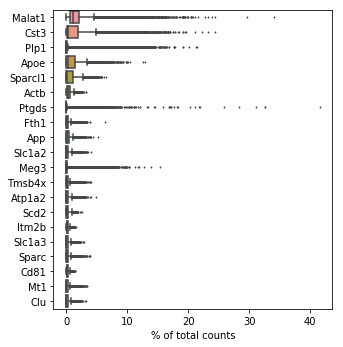

AnnData object with n_obs × n_vars = 24012 × 11670 
    obs: 'n_genes', 'n_counts'
    var: 'n_cells'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [7]:
# normalize and filter
sc.pl.highest_expr_genes(adata, n_top=20)
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=400)

adata = adata[adata.obs['n_genes'] < 3500, :]

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4, copy=True)
adata.raw = adata
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4, copy=True)

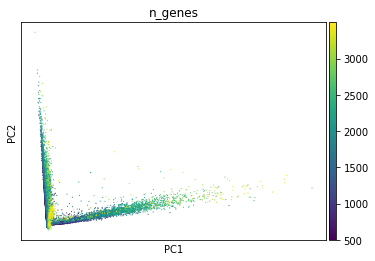

In [8]:
# pca
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='n_genes')

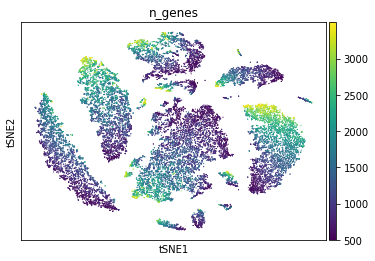

In [9]:
# tsne
ts_adata = sc.tl.tsne(adata)
sc.pl.tsne(adata, color='n_genes')

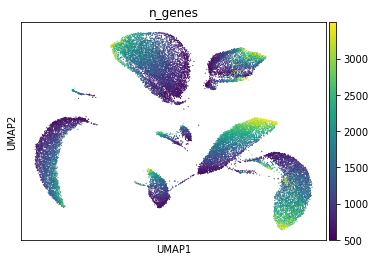

In [10]:
# umap
sc.pp.neighbors(adata, n_neighbors=1000, n_pcs=50)
sc.tl.umap(adata)
sc.pl.umap(adata, color='n_genes')

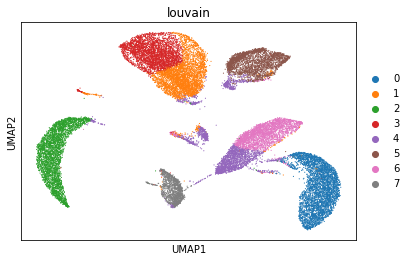

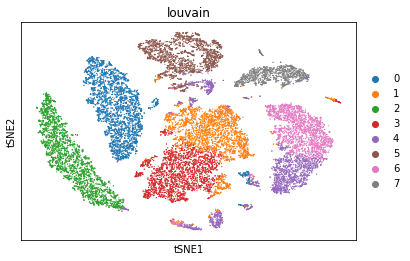

In [11]:
# louvain
sc.tl.louvain(adata)
sc.pl.umap(adata, color=['louvain'], use_raw=False)
sc.pl.tsne(adata, color=['louvain'], use_raw=False)
adata.write(results_file)

In [45]:
# Export single fields of the annotation of observations
adata.obs[['n_genes', 'louvain']].to_csv('./write/full_run.csv')

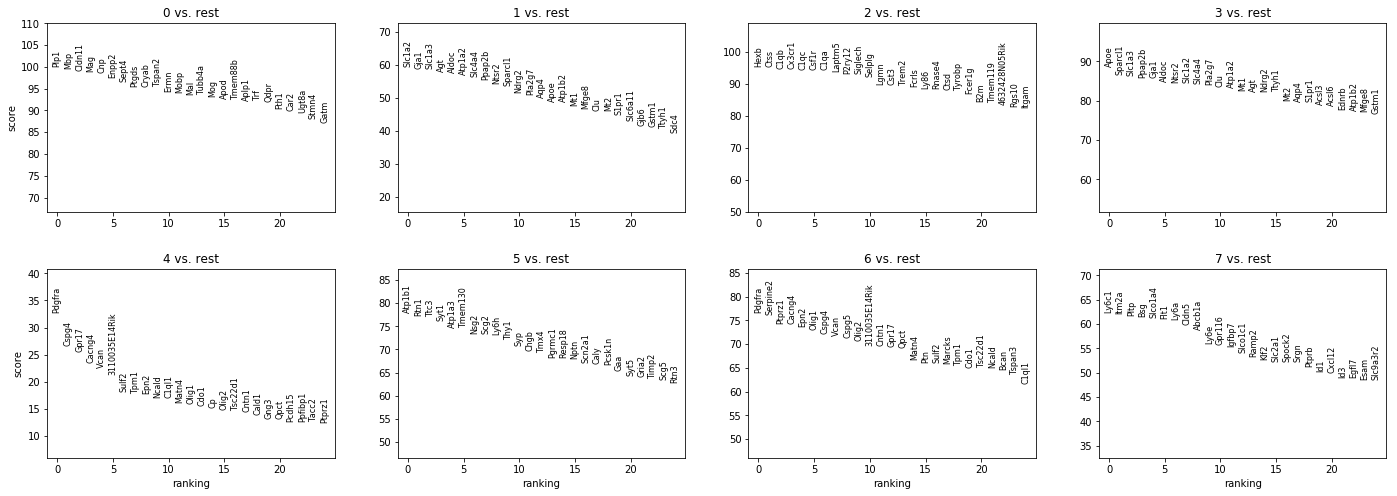

In [12]:
# finding marker genes 
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
adata.write(results_file)

In [ ]:
pandas.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
new_df = pandas.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']})
new_df.to_csv('./write/full_groups_run.csv', sep=' ')

In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

In [18]:
"""
run for final.py
new_cluster_names = [
    'Astrocyte', 'OPC-OL',
    'Microglia', 'Mural',
    'Neurons', 'OPC',
    'Oligo', 'Endothelial']
"""
new_cluster_names = ['OPC-OL', 'Astrocyte', 'Microglia', 'Mural', 'OPC', 'Neurons', 'Oligo', 'Endothelial']
adata.rename_categories('louvain', new_cluster_names)

saving figure to file ./figures/tsne.pdf


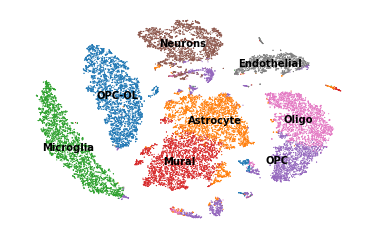

In [19]:
sc.pl.tsne(adata, color='louvain', legend_loc='on data', title='', frameon=False, save='.pdf')

saving figure to file ./figures/umap.pdf


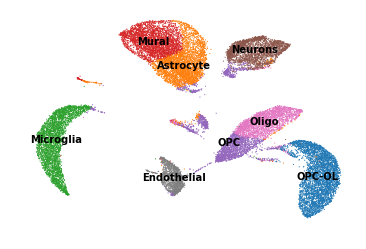

In [20]:
sc.pl.umap(adata, color='louvain', legend_loc='on data', title='', frameon=False, save='.pdf')

In [16]:
# Export single fields of the annotation of observations
adata.obs[['n_genes', 'louvain']].to_csv('./write/full_run.csv')

In [17]:
# Export single columns of the multidimensional annotation
adata.obsm.to_df()[['X_tsne1', 'X_tsne2']].to_csv('./write/full_names_tsnedat.csv')

# KMeans

In [82]:
filename = './write/full_names_tsnedat.csv'
X = pandas.read_csv(filename)

In [83]:
ids = X.iloc[:,0]
X.index = ids
X_vals = X.values[:, 1:]
print(X_vals)
X.head()

[[-31.39343   93.14762 ]
 [-19.373009  32.161533]
 [ 34.417744  48.392467]
 ...
 [ 13.14408   76.24686 ]
 [ 30.05434   18.857708]
 [ 35.512047  15.20516 ]]


,Unnamed: 0,X_tsne1,X_tsne2
Unnamed: 0,,,
0,0,-31.393430,93.147620
1,1,-19.373009,32.161533
2,2,34.417744,48.392467
3,3,-10.151172,46.054337
4,4,-2.525208,98.501850


In [137]:
# Using sklearn kmeans
km = KMeans(n_clusters=8, init="k-means++")
km = km.fit(X_vals)
y_kmeans = km.predict(X_vals)

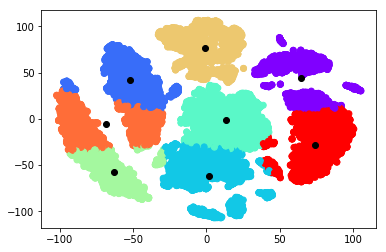

In [138]:
plt.figure
plt.scatter(X_vals[:,0], X_vals[:,1], c=km.labels_, cmap='rainbow')
centers = km.cluster_centers_
plt.scatter(centers[:,0], centers[:, 1], c='black')
plt.show()

In [139]:
print("writing results to file")
kmeans_filename = 'kmeans_names.txt'
X_kmeans = np.column_stack((X_vals, y_kmeans))
np.savetxt(kmeans_filename, X_kmeans, delimiter="\t", fmt='%s')

writing results to file


# Classification 

In [158]:
df = pandas.read_csv('kmeans_names.txt', sep='\s+', header=None)
df.head()

,0,1,2
0,-31.393430,93.147620,5.0
1,-19.373009,32.161533,1.0
2,34.417744,48.392467,0.0
3,-10.151172,46.054337,5.0
4,-2.525208,98.501850,5.0


In [159]:
X = df.iloc[:, 0:2]
y = df.iloc[:, 2]

In [160]:
print(set(y))

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0}


In [161]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from statistics import mean

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size = 0.65)

# KNN

In [162]:
scores = {}
scores_list = []
for k in range(1,25):  
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    knn_pred = neigh.predict(X_test)
    scores[k] = metrics.accuracy_score(y_test, knn_pred)
    scores_list.append(scores[k])
print(mean(scores_list))

0.9932806893900564


In [145]:
print(min(scores_list))

0.9882573625961358


# AdaBoost

In [163]:
# try for different number of trees and learning rates 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_validate

ada_class = AdaBoostClassifier(n_estimators=200, learning_rate=3)
model = ada_class.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))
cv_results = cross_validate(ada_class, X, y, cv=10, return_train_score=True)
sorted(cv_results.keys())
print(mean(cv_results['test_score']))

0.970912352639672
0.9518920016235597


In [164]:
# try for different number of trees and learning rates 
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=52)
model = rf.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))
cv_results = cross_validate(rf, X, y, cv=10, return_train_score=True)
sorted(cv_results.keys())
print(mean(cv_results['test_score']))

0.9803946694003075
0.9779653179834799


In [129]:
rf.feature_importances_

array([0.53363779, 0.46636221])

# Neural Networks (MLP) 

In [165]:
from sklearn.neural_network import MLPClassifier 
from sklearn.metrics import classification_report,confusion_matrix
mlp = MLPClassifier()
mlp.fit(X_train, y_train)
mlp_pred = mlp.predict(X_test)
print(confusion_matrix(y_test,mlp_pred))
print(classification_report(y_test,mlp_pred))
print(metrics.accuracy_score(y_test, mlp_pred))
cv_results = cross_validate(mlp, X, y, cv=10, return_train_score=True)
sorted(cv_results.keys())
print(mean(cv_results['test_score']))

/Users/michellevoong/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[[1553    0    0    0    0    0    0   18]
 [   0 1745    0    0    0    0    0    0]
 [   0    0 2289    2    0    0    0    6]
 [   0    0   10 2443    0    0    0   12]
 [   0    0   28    0 1253    0   39    0]
 [   0    0    0    0    0 1913    0    0]
 [   0    6    0    0    0    0 1973    0]
 [   0    0    6    0    0    0    0 2312]]
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      1571
         1.0       1.00      1.00      1.00      1745
         2.0       0.98      1.00      0.99      2297
         3.0       1.00      0.99      1.00      2465
         4.0       1.00      0.95      0.97      1320
         5.0       1.00      1.00      1.00      1913
         6.0       0.98      1.00      0.99      1979
         7.0       0.98      1.00      0.99      2318

   micro avg       0.99      0.99      0.99     15608
   macro avg       0.99      0.99      0.99     15608
weighted avg       0.99      0.99      0.99     15608

0.99

In [149]:
print(metrics.accuracy_score(y_test, mlp_pred))

0.9852185331082348


# ROC Curve

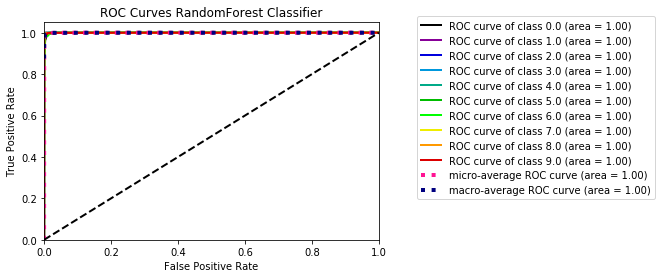

In [150]:
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=200, max_depth=5, random_state=52))
y_score = clf.fit(X_train, y_train).predict_proba(X_test)

# The magic happens here
import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_roc(y_test, y_score, title ="ROC Curves RandomForest Classifier")
plt.legend(bbox_to_anchor=(1.1,1.05))
plt.show()

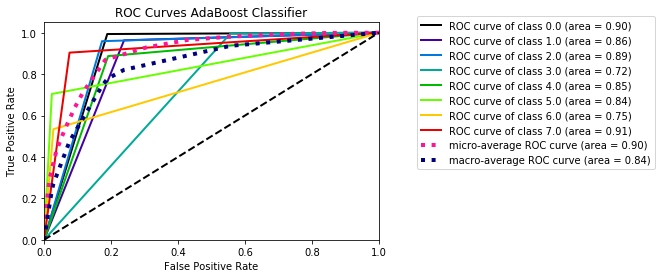

In [166]:
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(AdaBoostClassifier(n_estimators=200, learning_rate=0.0000000000001))
y_score = clf.fit(X_train, y_train).decision_function(X_test) 

# The magic happens here
import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_roc(y_test, y_score, title ="ROC Curves AdaBoost Classifier")
plt.legend(bbox_to_anchor=(1.1,1.05))
plt.show()

In [1]:
from sklearn.model_selection import cross_val_predict

predictions = cross_val_predict(clf, X, y)
skplt.metrics.plot_confusion_matrix(y, predictions, normalize=True)

NameError: name 'clf' is not defined

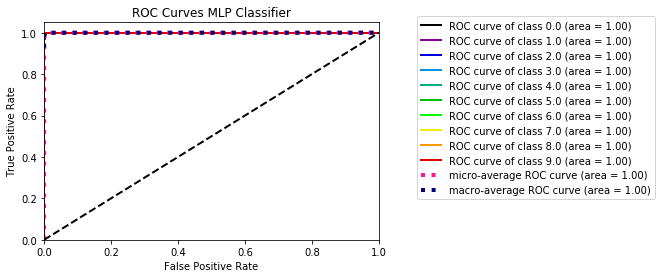

In [109]:
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(50,50,50)))
y_score = clf.fit(X_train, y_train).predict_proba(X_test) 

# The magic happens here
import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_roc(y_test, y_score, title ="ROC Curves MLP Classifier")
plt.legend(bbox_to_anchor=(1.1,1.05))
plt.show()

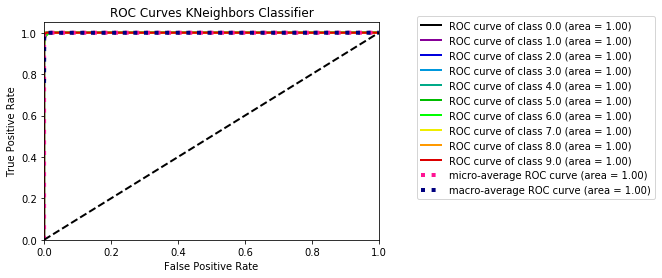

In [115]:
clf = OneVsRestClassifier(KNeighborsClassifier(25))
y_score = clf.fit(X_train, y_train).predict_proba(X_test) 

# The magic happens here
import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_roc(y_test, y_score, title ="ROC Curves KNeighbors Classifier")
plt.legend(bbox_to_anchor=(1.1,1.05))
plt.show()

In [35]:
adata

AnnData object with n_obs × n_vars = 24012 × 11670 
    obs: 'n_genes', 'louvain'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'louvain', 'louvain_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

In [44]:
filename = './write/full_run_names.csv'
X = pandas.read_csv(filename)

In [38]:
ids = X.iloc[:,0]
X.index = ids
X_vals = X.values[:, 1:]
print(X_vals)

X.head()

[[3485 'OPC']
 [3494 'Astrocyte']
 [3421 'Endothelial']
 ...
 [500 'OPC']
 [500 'OPC-OL']
 [501 'OPC-OL']]


,Unnamed: 0,n_genes,louvain
Unnamed: 0,,,
TGCGTATATTTN_M1_N,TGCGTATATTTN_M1_N,3485,OPC
TTCTTGATGCGT_M1_OPC-OL,TTCTTGATGCGT_M1_OPC-OL,3494,Astrocyte
CATTTTGCTAAT_M1_EN,CATTTTGCTAAT_M1_EN,3421,Endothelial
ACCAGCGTGGTG_M1_N,ACCAGCGTGGTG_M1_N,3428,OPC
GTTAGTGAATAT_M1_N,GTTAGTGAATAT_M1_N,3429,OPC


In [39]:
# Using sklearn kmeans
km = KMeans(n_clusters=8)
km = km.fit(X_vals)
y_kmeans = km.predict(X_vals)

ValueError: could not convert string to float: 'OPC-OL'

In [ ]:
Dlx1
Dlx2
Dlx6os1
Cdca7
Sp9
Ccnd2
Pak3
Nrxn3
Dlx5
Ckb
Dleu7
Rbp1
Hmgn2
Ascl1
Hat1
Meg3
Gadd45g
Nudt4
Nnat
Zic1